In [2]:
import numpy as np
from matplotlib import pyplot as plt

import celerite
from celerite import terms

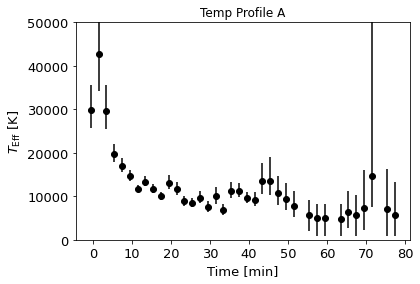

In [3]:
data_times, data_temps, data_lowerr, data_upperr, data_formal_lowerr, data_formal_upperr = np.load("flareAreal.npy")

real_times = (data_times[data_temps>900.0]-0.0573)*24.0*60.0
real_temps = data_temps[data_temps>900.0]
real_uppererr = data_formal_upperr[data_temps>900.0]
real_lowererr = data_formal_lowerr[data_temps>900.0]

plt.errorbar(real_times, real_temps, yerr=[real_lowererr, real_uppererr], marker="o", color="black", ls="none",zorder=0.05)

plt.xlabel("Time [min]",color="black", fontsize=13)
plt.ylabel("$T_\mathrm{Eff}$ [K]", fontsize=13)
plt.ylim(0,50000)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.title("Temp Profile A")
plt.show()

/var/folders/yy/7pyksq_x7bgc3xfdxf46nphm0000gn/T/ipykernel_28867/999315193.py:2: RuntimeWarning: invalid value encountered in log10
  log_times = np.log10(real_times)


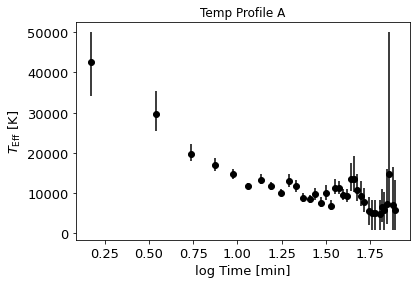

In [33]:
#make the TIME axis logspace
log_times = np.log10(real_times)

plt.errorbar(log_times, real_temps, yerr=[real_lowererr, real_uppererr], marker="o", color="black", ls="none",zorder=0.05)

plt.xlabel("log Time [min]",color="black", fontsize=13)
plt.ylabel("$T_\mathrm{Eff}$ [K]", fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.title("Temp Profile A")
plt.show()

In [60]:
a1 = 50000
a2 = 20000
c1 = 0.2
c2 = 0.02

bounds = dict(log_a=(1,100), log_c=(-15,15))
term1 = terms.RealTerm(log_a = np.log(a1), log_c = np.log(c1), bounds=bounds)
term2 = terms.RealTerm(log_a = np.log(a2), log_c = np.log(c2), bounds=bounds)

kernel = term1

In [61]:
#Create GP
gp = celerite.GP(kernel)
gp.compute(log_times, yerr = real_uppererr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(real_temps)))

Initial log likelihood: -inf


In [62]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:log_a', 10.819778284410283), ('kernel:log_c', -1.6094379124341003)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[10.81977828 -1.60943791]

parameter_bounds:
[(1, 100), (-15, 15)]



In [63]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(real_temps, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: inf
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([10.81977828, -1.60943791])


In [64]:
x = np.logspace(-20, 80, 1000)
pred_mean, pred_var = gp.predict(real_temps, x, return_var=True)
pred_std = np.sqrt(pred_var)

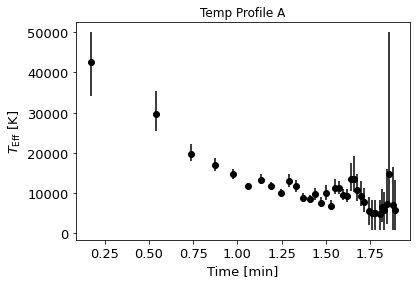

In [65]:
color = "#ff7f0e"
plt.errorbar(log_times, real_temps, yerr=[real_lowererr, real_uppererr], 
             marker="o", color="black", ls="none",zorder=0.05)

plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.xlabel("Time [min]",color="black", fontsize=13)
plt.ylabel("$T_\mathrm{Eff}$ [K]", fontsize=13)
#plt.yscale('log')
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.title("Temp Profile A");